C:\Users\gonibix23\AppData\Local\Temp\ipykernel_9944\4290046387.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indices["recorder_zone"] = df_indices.apply(lambda row: f"{row['recorder']} ({row['zone']})", axis=1)


Matriz de correlación:
           ACI       ADI       AEI       BIO      NDSI         H        AR
ACI   1.000000 -0.093358  0.153398  0.279924 -0.019228 -0.158239 -0.223662
ADI  -0.093358  1.000000 -0.940407 -0.096957  0.400599  0.857546  0.585977
AEI   0.153398 -0.940407  1.000000  0.240716 -0.408007 -0.876459 -0.697870
BIO   0.279924 -0.096957  0.240716  1.000000 -0.103567 -0.300391 -0.427308
NDSI -0.019228  0.400599 -0.408007 -0.103567  1.000000  0.583848  0.122716
H    -0.158239  0.857546 -0.876459 -0.300391  0.583848  1.000000  0.550810
AR   -0.223662  0.585977 -0.697870 -0.427308  0.122716  0.550810  1.000000


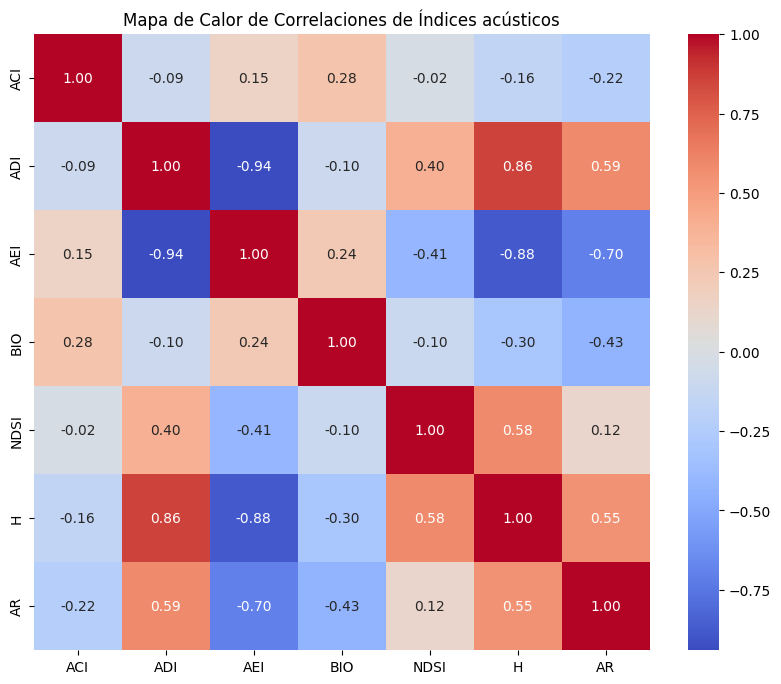

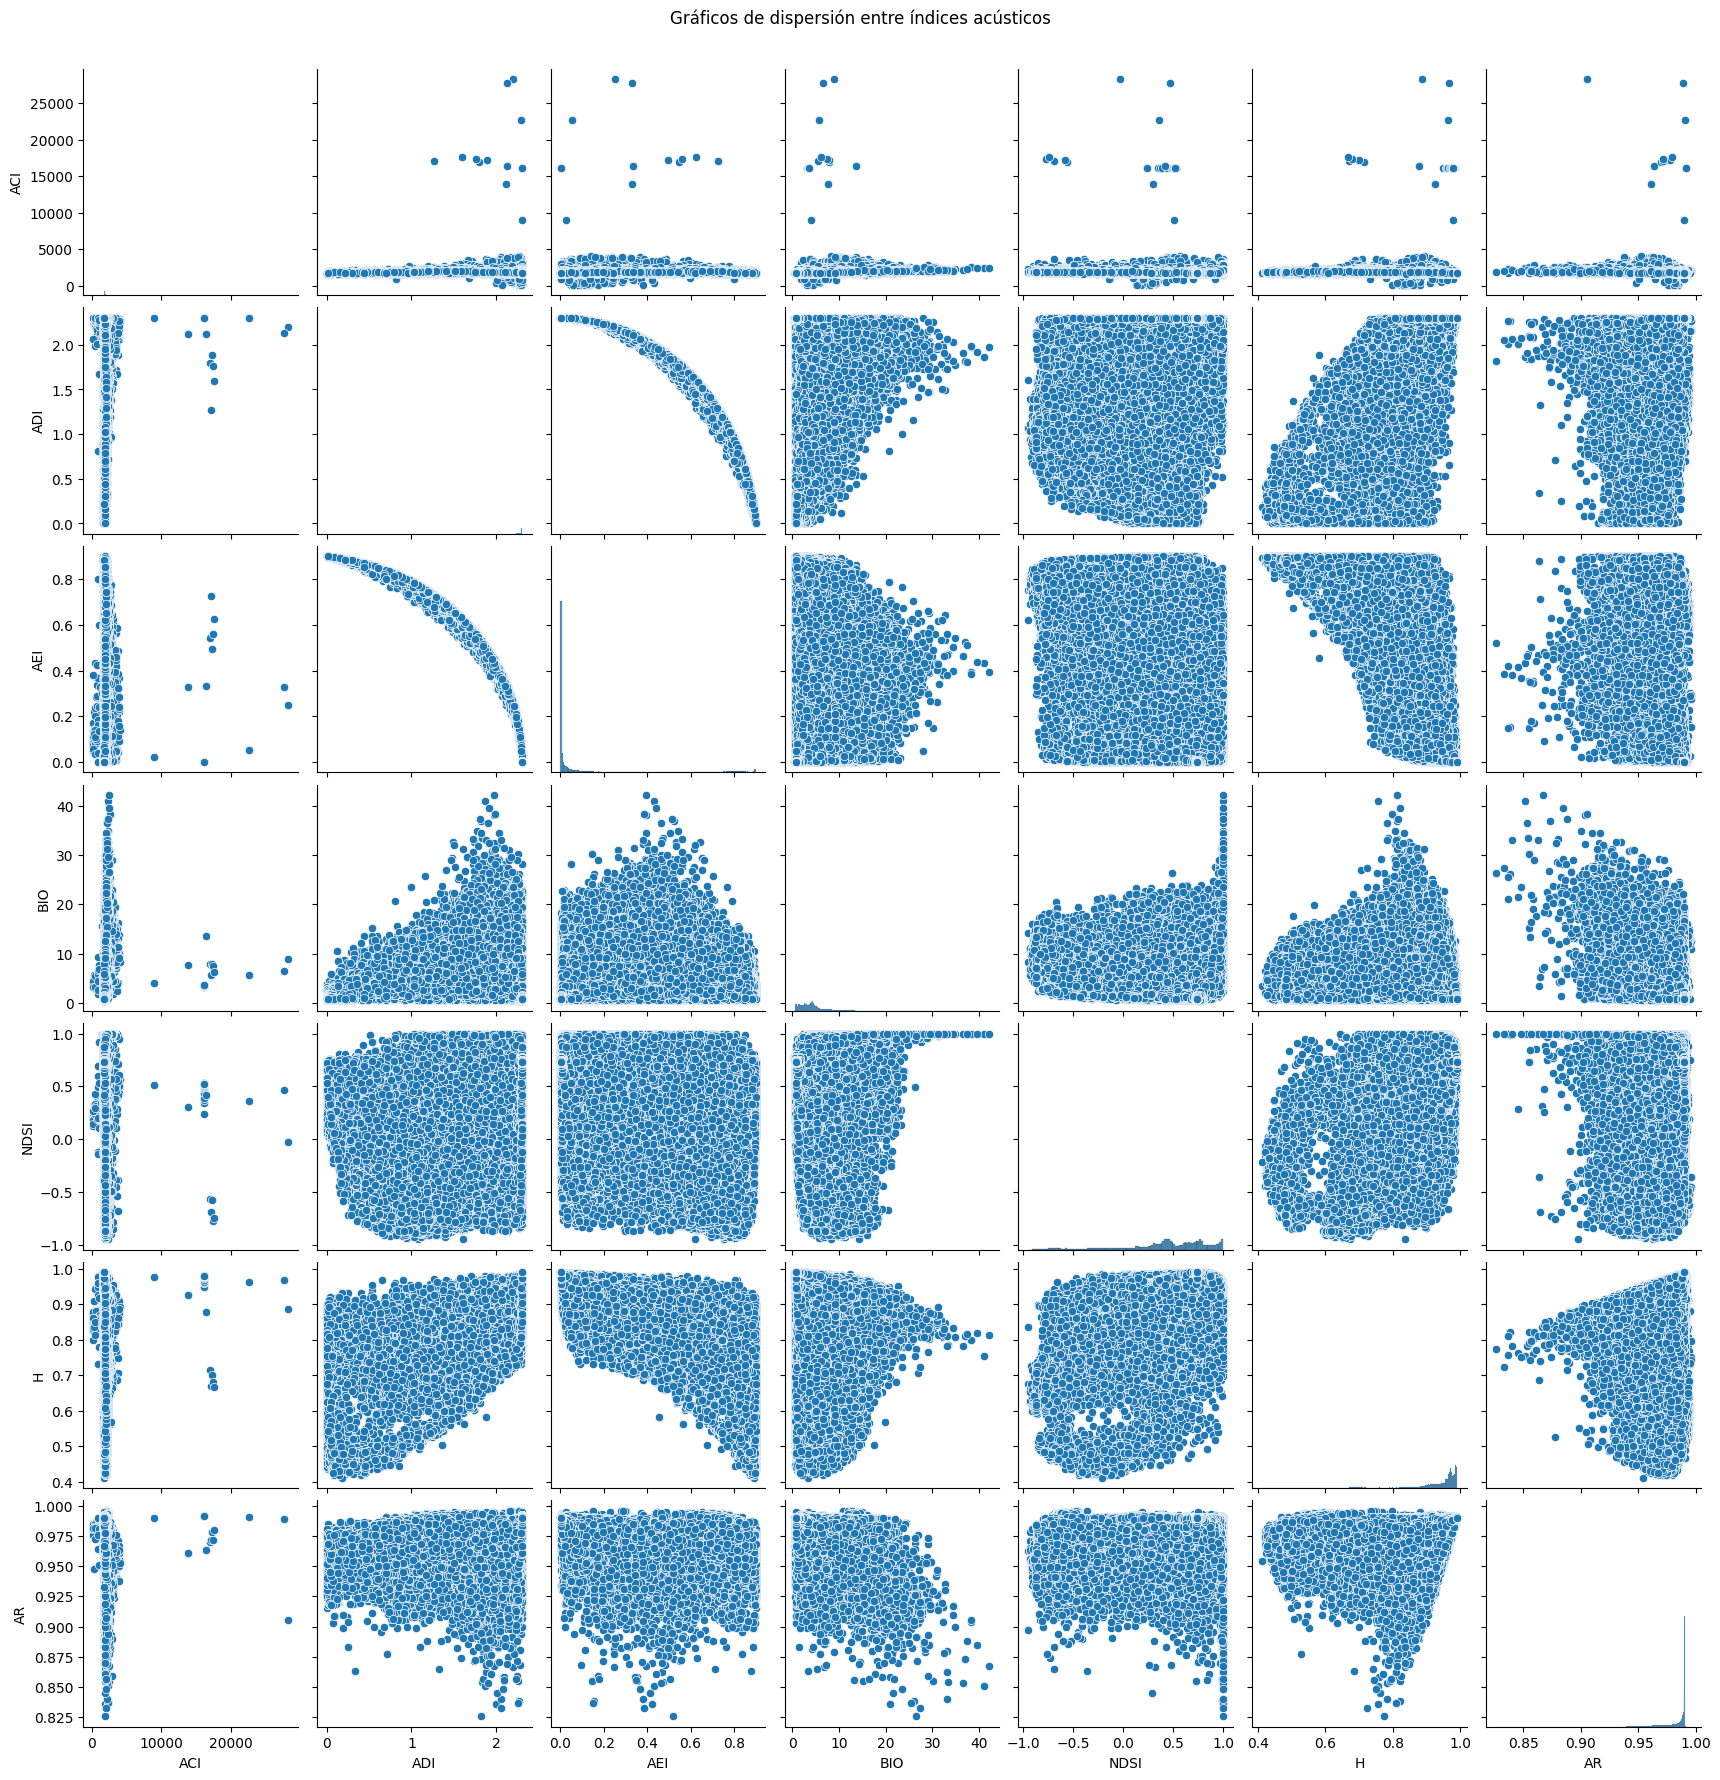

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Conectar a la base de datos y extraer la tabla "audio_metadata" (solo registros procesados) ---
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM audio_metadata WHERE processed = TRUE", conn)
df_obs = pd.read_sql_query("SELECT o.recorder, o.datetime, o.bird, r.zone FROM observations o LEFT JOIN recorders r ON r.recorder = o.recorder", conn)
conn.close()

# Convertir la columna "datetime" a tipo datetime, si existe
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"])

# --- 2. Preparar los datos ---
# Lista de índices a evaluar
indices = ["ACI", "ADI", "AEI", "BIO", "NDSI", "H", "AR"]

# Eliminar filas con valores NA en al menos alguno de los índices y en "zone"
df_indices = df.dropna(subset=indices + ["zone"])

# Crear una columna combinada "recorder_zone" para visualizar grabadora y zona juntas (opcional)
df_indices["recorder_zone"] = df_indices.apply(lambda row: f"{row['recorder']} ({row['zone']})", axis=1)

# --- 3. Cálculo del índice de Shannon por zona ---
# Para el índice de Shannon, supongamos que 'bird' es la especie o categoría de la observación
# Primero, agrupar las observaciones por zona y bird
df_shannon = df_obs.groupby(["zone", "bird"]).size().reset_index(name="count")

# Calcular la proporción de cada 'bird' en cada zona
df_shannon["proporcion"] = df_shannon.groupby("zone")["count"].transform(lambda x: x / x.sum())

# Calcular el índice de Shannon por zona
df_shannon["shannon"] = -df_shannon["proporcion"] * np.log(df_shannon["proporcion"])
shannon_index = df_shannon.groupby("zone")["shannon"].sum().reset_index(name="shannon_index")

# --- 4. Unir los índices calculados con el DataFrame original ---
# Unir los índices de Shannon por zona con los datos procesados por zona
df_indices_with_shannon = df_indices.merge(shannon_index, on="zone", how="left")

# --- 5. Análisis de correlación ---
# Calcular la matriz de correlación de los índices
corr_matrix = df_indices_with_shannon[indices].corr()

print("Matriz de correlación:")
print(corr_matrix)

# --- 6. Visualización: Mapa de Calor de Correlaciones ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Mapa de Calor de Correlaciones de Índices acústicos")
plt.show()

# --- 7. Visualización opcional: Pairplot de los índices ---
sns.pairplot(df_indices_with_shannon[indices])
plt.suptitle("Gráficos de dispersión entre índices acústicos", y=1.02)
plt.show()
